In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

## 5.1 Bayesian Computation

### Simulated Case 

In [5]:
# simulated one N(theta, 1)
x = 2
N = 100000
num = 0
denom = 0

for i in range(N):
    theta = x + np.random.randn()
    num = num + theta/(1+theta**2)
    denom = denom + 1/(1+theta**2)
delta21 = num/denom
delta21

1.2903616678140268

In [20]:
# simulated two
x = 2
N = 100000
num = 0
denom = 0

for i in range(N):
    a = np.random.randn(1, 2) + 2
    theta = a[0][0]/a[0][1]
    num = num + theta * np.exp(-0.5 * (x-theta)**2)
    denom = denom + np.exp(-0.5 * (x-theta)**2)
delta21 = num/denom
delta21

1.3380404812458386

In [21]:
# Not simulated
from scipy import integrate

In [26]:
x = 2
num = lambda th: th * np.exp(-0.5*(x-th)**2)/(1+th**2)
denom = lambda th: np.exp(-0.5*(x-th)**2)/(1+th**2)
delta2 = integrate.quad(num, -np.infty, np.infty)[0]/integrate.quad(denom, -np.infty, np.infty)[0]
delta2

1.2821951026935339

In [27]:
# Errors

numerator =integrate.quad(num,-np.infty, np.infty)[0]    #0.9159546679977636
denominator=integrate.quad(denom,-np.infty, np.infty)[0] #0.714364503556127
errnum=integrate.quad(num,-np.infty, np.infty)[1]        #1.0415234856193602e-09
errdenom=integrate.quad(denom,-np.infty, np.infty)[1]    #1.2022419107752649e-08

err = delta2 * (errnum/numerator + errdenom/denominator)
print(err)   #2.3036713479165735e-08

2.3036713551596704e-08


### Laplace Approximation

In [58]:
from scipy.stats import gamma
from scipy.stats import norm

In [59]:
# x|theta ~ Ga(r, theta), theta ~ Ga(alpha, beta)
r = 20
alpha = 5
beta = 1
x = 2

xx = np.arange(0, 16, 0.01)

y1 = gamma.pdf(xx, a=r+alpha, scale=1/(beta+x))
y2 = norm.pdf(xx, (r-1+alpha)/(beta+x), np.sqrt(r-1+alpha)/(beta+x))

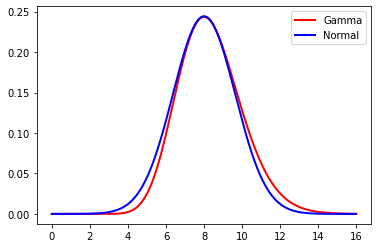

In [60]:
plt.plot(xx, y1, c="r", linewidth=2)
plt.plot(xx, y2, c="b", linewidth=2)
plt.legend(["Gamma", "Normal"])
plt.show()

In [61]:
# 95% Credible Set
norm.ppf(0.025, (r-1+alpha)/(beta+x), np.sqrt(r-1+alpha)/(beta+x)), norm.ppf(0.975, (r-1+alpha)/(beta+x), np.sqrt(r-1+alpha)/(beta+x))

(4.799392215763127, 11.200607784236873)

In [62]:
upper = gamma.cdf(11.200607784236873, a=r+alpha, scale=1/(beta+x))
lower = gamma.cdf(4.799392215763127, a=r+alpha, scale=1/(beta+x))

In [63]:
# approximate posterior range
upper - lower

0.9404006787256667

In [77]:
# Exact 
from scipy.special import gamma
gamma(r+alpha)/ (beta+x)**(r+alpha)

732275159630.8094

In [79]:
np.sqrt(2 * np.pi) * (r+alpha-1)**(r + alpha -1/2) /((beta + x)**(r +alpha)) * np.exp(-(r+alpha -1))

729737093278.3551

## 5.2 Metropolis Algorithm


X | $\theta$ ~ N($\theta$, 1) and $\theta$ ~ Cauchy(0, 1) Example

In [21]:
from scipy.stats import uniform

In [28]:
x = 2 #observed value
the = 1 # initial value
thes = [] # collection 

for i in range(100000):
    theta_prop = np.random.randn() + x # get candidates
    r = (1+the**2)/(1+theta_prop**2)
    rho = min(r, 1)
    if uniform.rvs() < rho:
        the = theta_prop
        thes.append(the)
    else:
        thes.append(the)

In [29]:
np.mean(thes[500:])

1.281274908022895

In [30]:
np.var(thes[500:])

0.8716909046964324

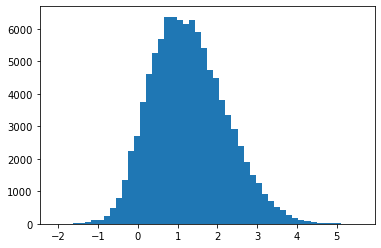

In [34]:
plt.hist(thes, bins=50)
plt.show()

Weibull Distribution

Modified from C. Robert Bayesian Choice Springer, 2nd edition Page 305

Weibull lifetimes
$f(t|\alpha, \eta) = \alpha \eta t^(\alpha-1) exp(- \eta t^\alpha)$

Prior on (alpha, eta) is proportional to 

   $exp(-\alpha) \eta^(\beta-1) exp(-\xi \eta)$
   
As proposal conditional density for alpha' and eta' use 
the product of two exponential densities with means alpha and eta.

In [66]:
T = np.array([0.2, 0.1, 0.25])
n = 3
alpha = 2 #initial
eta = 2 #initial
beta = 2
xi = 2

In [67]:
alphas = []
etas = []

In [68]:
for i in range(50000):
    alpha_prop = - alpha * np.log(uniform.rvs())
    eta_prop = - eta * np.log(uniform.rvs())
    
    prod1 = np.prod(T)
    prod2 = np.prod(np.exp(eta * (T ** alpha) - eta_prop * (T ** alpha_prop)))
    
    rr = (eta_prop/eta)**(beta-1) * np.exp(alpha-alpha_prop - xi * (eta_prop - eta))\
         * np.exp(-alpha/alpha_prop - eta/eta_prop + alpha_prop/alpha + eta_prop/eta) \
         * (prod1 ** (alpha_prop-alpha)) * prod2 * (((alpha_prop * eta_prop)/(alpha * eta))**(n-1))
    rho = min(rr, 1)
    if uniform.rvs() < rho:
        alpha = alpha_prop
        eta = eta_prop
        alphas.append(alpha)
        etas.append(eta)
    else:
        alphas.append(alpha)
        etas.append(eta)

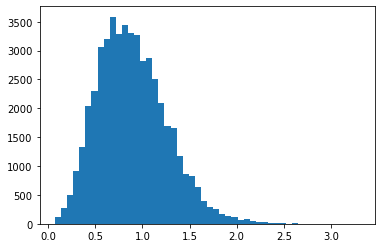

In [75]:
plt.hist(alphas[500:], bins=50)
plt.show()

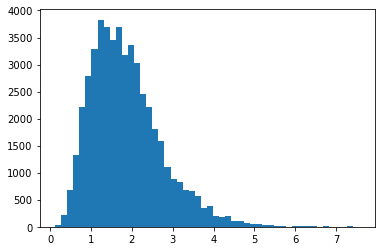

In [77]:
plt.hist(etas[500:], bins=50)
plt.show()

In [78]:
np.mean(alphas)

0.8963375619986392

In [79]:
np.mean(etas)

1.8718612583443595

In [80]:
np.var(alphas)

0.13525370761250824

In [81]:
np.var(etas)

0.7689196085042022

## 5.3 Gibbs Sampling

Example 1

In [93]:
x=2
sigma2 = 1
tau2 = 1
mu = 0

In [100]:
theta = 0
thetas =[theta]
lamda = 1
lambdas=[lamda]
burn =1000
ntotal = 10000 + burn
for i in range(ntotal):
    theta = (tau2/(tau2 + lamda * sigma2)) * x \
             + (lamda * sigma2/(tau2 + lamda * sigma2)) * mu \
             + np.sqrt(tau2 * sigma2/(tau2 + lamda *sigma2)) * np.random.randn()
    lamda =  np.random.exponential(1/((tau2 + (theta - mu)**2)/(2*tau2)))
    thetas.append(theta)
    lambdas.append(lamda)

In [101]:
np.mean(thetas[burn+1:])

1.261643825409876

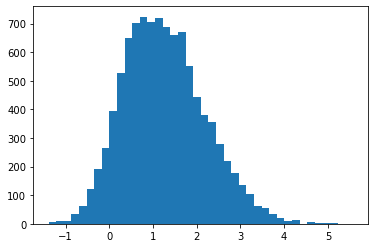

In [102]:
plt.hist(thetas[burn+1:], bins=40)
plt.show()

Example 2

data drom Gaver and O'Muircheartaigh, 1987

In [105]:
X = [5, 1, 5, 14, 3, 19, 1, 1, 4, 22]
t = [94.32, 15.52, 62.88, 125.76,
    5.24, 31.44, 1.048, 1.048, 2.096, 10.48]

In [106]:
n=10
c=0.1
d=1

In [107]:
theta = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
beta =1

In [109]:
B=50000;
thetas=[]; 
betas=[];

for i in range(B):
    for j in range(n):
        theta[j] = np.random.gamma(X[j]+1, 1/(beta + t[j]))
    sumthetas = sum(theta)
    beta =np.random.gamma(n + c, 1/(sumthetas + d))
    thetas.append(theta)
    betas.append(beta)

In [118]:
burn=1000;
thetasb = thetas[burn+1:]
betasb = betas[burn+1:]

In [119]:
np.mean(np.array(thetasb), axis=0)

array([0.03302256, 0.07887263, 0.06759132, 0.15115574, 0.60821703,
       0.80885038, 3.10916751, 0.56870919, 2.21030404, 2.48651803])

In [120]:
np.mean(betasb)

1.338788063697181

Example 3

In [143]:
x ="4     5     4     1     0     4     3     4     0     6     3     3     4     0     2     6     3     3     5     4     5     3 \
     1     4     4     1     5     5     3     4     2     5     2     2     3     4     2     1     3     2     2     1     1     1 \
     1     3     0     0     1     0     1     1     0     0     3     1     0     3     2     2     0     1     1     1     0     1 \
     0     1     0     0     0     2     1     0     0     0     1     1     0     2     3     3     1     1     2     1     1     1 \
     1     2     4     2     0     0     0     1     4     0     0     0     1     0     0     0     0     0     1     0     0     1 \
     0     1"

year = [i for i in range(1851, 1963)]

In [144]:
# x is the number of coal mine disasters per year
x = [int(i) for i in list(x.replace(" ", ""))]

In [149]:
n = len(x)
NN = 10500
burn = 500 #burn
lamda = np.zeros(NN);
mu = np.zeros(NN);
m = np.zeros(NN);
posteriorm = np.zeros(n)

In [150]:
m[0]= 10;
lamda[0] = 4; #initial lambda
mu[0] = 1/2;  #initial mu

In [151]:
alpha = 4; #hyperparameter
beta = 1; #hyperparameter
gamma = 1/2; #hyperparameter
delta = 1; #hyperparameter

In [162]:
for i in range(1, NN):
    mm = m[i-1];  
    mm = int(mm)
   # Get parameters for generating lambda
    alpha1 = alpha + sum(x[1:mm]);
    beta1 = mm + beta;
   # Generate the variate for lambda.
    lamda[i] = np.random.gamma(alpha1,1/beta1);
   #Get parameters for generating mu.
    gamma1 = gamma + sum(x) - sum(x[1:mm]);
    delta1 = n-mm+delta;
   # Generate the variate for mu.
    mu[i] = np.random.gamma(gamma1,1/delta1);
    #Now get the probabilities for m.
    for j in range(n):
        posteriorm[j] = np.exp((mu[i]-lamda[i])*(j+1))*(lamda[i]/mu[i]) ** sum(x[:j+1])
    posteriorm = posteriorm/ sum(posteriorm)
    m[i] = np.random.choice(n, 1, replace=True, p=posteriorm);

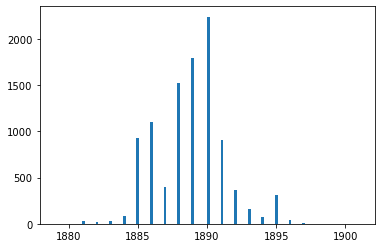

In [168]:
#hist(m(burn+1:NN)+1850, n)
plt.hist(m[burn+1:]+1850, n)
plt.show()

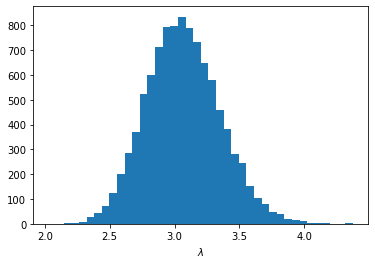

In [172]:
plt.hist(lamda[burn+1:], 40)
plt.xlabel('$\lambda$')
plt.show()

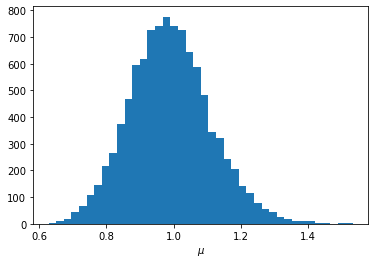

In [173]:
plt.hist(mu[burn+1:], 40)
plt.xlabel('$\mu$')
plt.show()